# Homework10 - Spatial Data Analysis (Citibike Ridership Summer vs. Winter)
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import random
random.seed(123)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Working with Shape File

### Loading Census Tract Shape File¶

In [1]:
from geopandas import GeoDataFrame
shape_path=os.getenv('PUIDATA') + '/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

SyntaxError: EOL while scanning string literal (<ipython-input-1-b04add6ee870>, line 2)

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

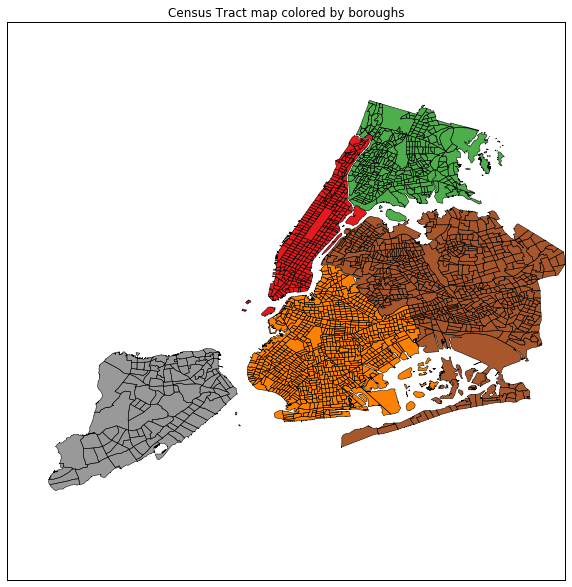

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv(os.getenv('PUIDATA') + '/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


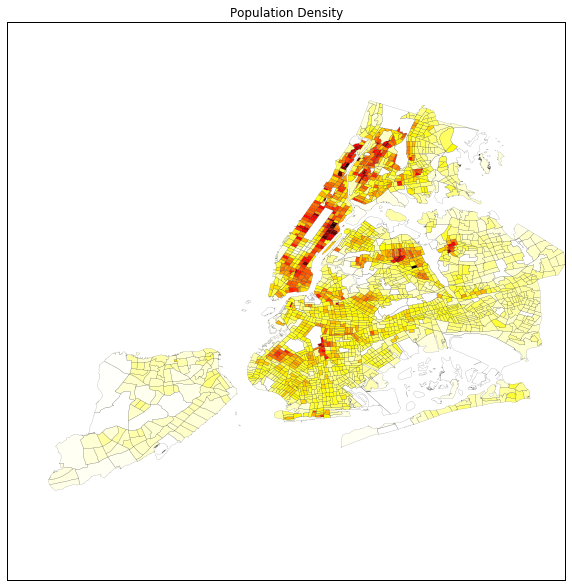

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv(os.getenv('PUIDATA') + '/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_bike_monthly.index

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30'],
              dtype='datetime64[ns]', name=u'starttime', freq=None)

In [11]:
df_bike_monthly.index.month

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6], dtype=int32)

In [12]:
df_bike_monthly['summer'] = [1 if (i.month >= 6 and i.month <= 9) else 0 for i in df_bike_monthly.index]
df_bike_monthly['winter'] = [1 if (i.month >= 1 and i.month <= 3) | (i.month==12) else 0 for i in df_bike_monthly.index]
df_bike_monthly_summer = df_bike_monthly[(df_bike_monthly.summer==1)]
df_bike_monthly_winter = df_bike_monthly[(df_bike_monthly.winter==1)]
df_bike_monthly_summer.head(12)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1535,1536,1537,1538,1539,1540,1541,1542,summer,winter
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,1,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,1,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,1,0
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,1,0
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,1,0
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,1,0
2014-09-30,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,1,0
2015-06-30,2309,0,9457,3426,5859,4763,1809,5190,2695,2116,...,0,0,0,0,0,0,0,0,1,0
2015-07-31,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,1,0


In [13]:
df_bike_monthly_winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1535,1536,1537,1538,1539,1540,1541,1542,summer,winter
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,1
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,1
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,1
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,1
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,1


### Time Series Aanalysis

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

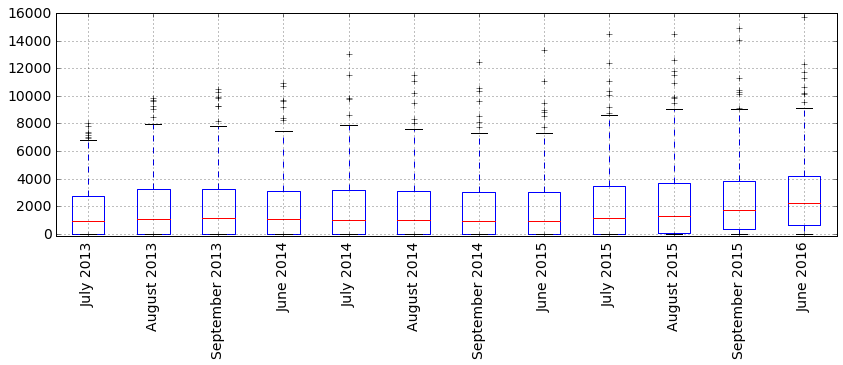

In [14]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly_summer.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

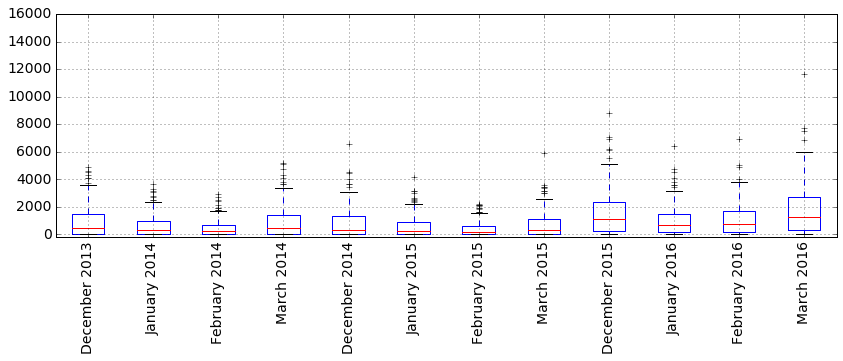

In [15]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly_winter.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


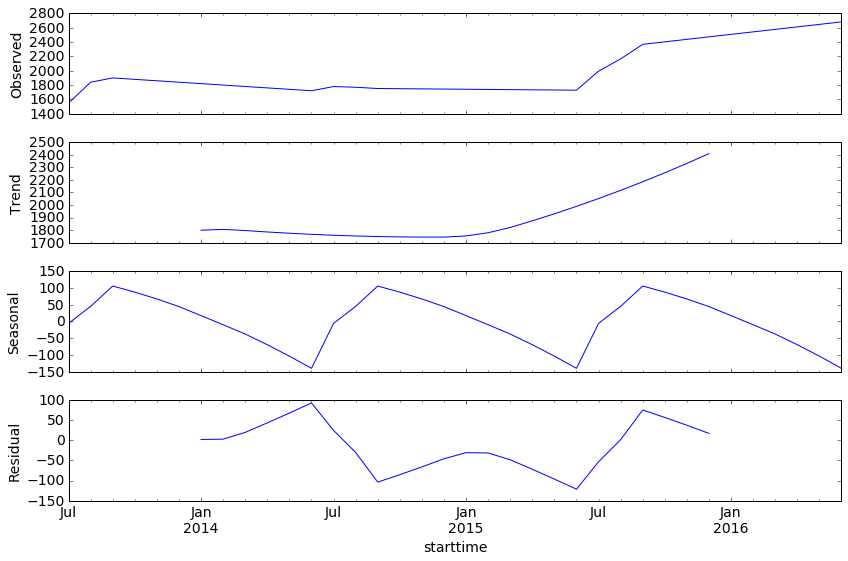

In [16]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly_summer.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [17]:
station_id=DataFrame.from_csv(os.getenv('PUIDATA') + '/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [18]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [19]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [20]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add SUMMER Monthly rides to the station GeoDataFrame with CT code

In [21]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve_summer']=df_bike_monthly_summer.sum()

### Add WINTER Monthly rides to the station GeoDataFrame with CT code

In [22]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve_winter']=df_bike_monthly_winter.sum()

In [23]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve_summer,MonthlyAve_winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,30696,13163
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,45966,16113
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,118837,52940
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,44794,19541
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,82749,31319


### Add the monthly average rides to the CT shapefile 

In [24]:
# use the 
temp=station_id[['MonthlyAve_summer', 'MonthlyAve_winter']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


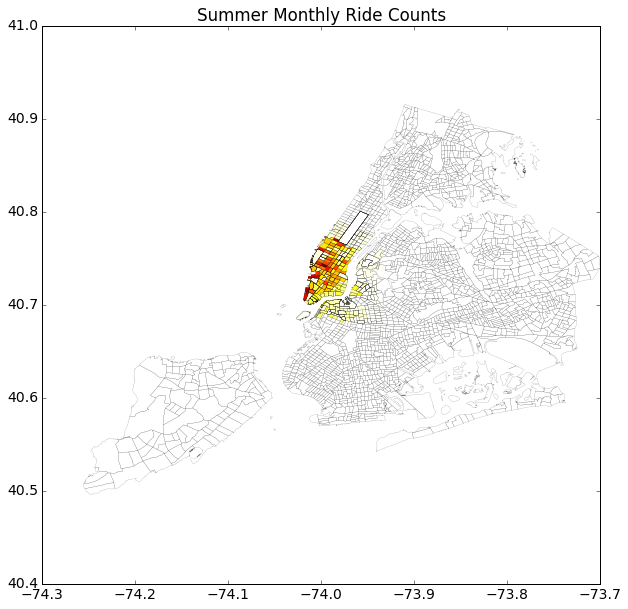

In [25]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve_summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

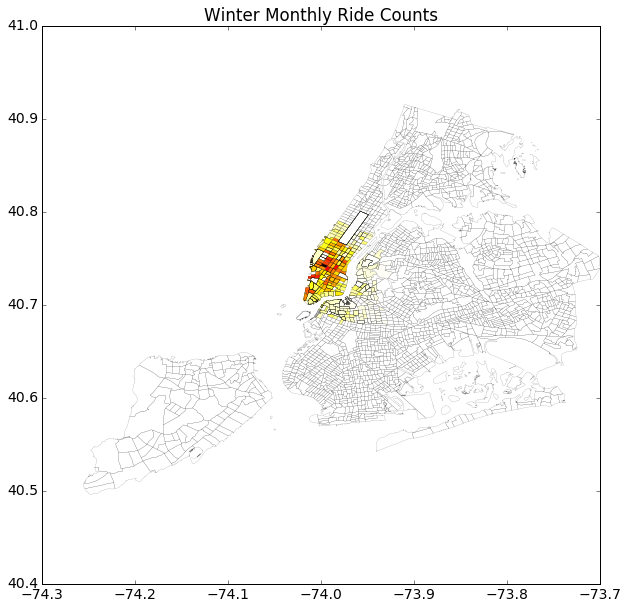

In [26]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve_winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [27]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [28]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs (summer):", len(temp.MonthlyAve_summer)
print "Number of zoomed CTs (winter):", len(temp.MonthlyAve_winter)


Total number of CTs: 2166
Number of zoomed CTs (summer): 543
Number of zoomed CTs (winter): 543


### Map the monthly rides in Summer

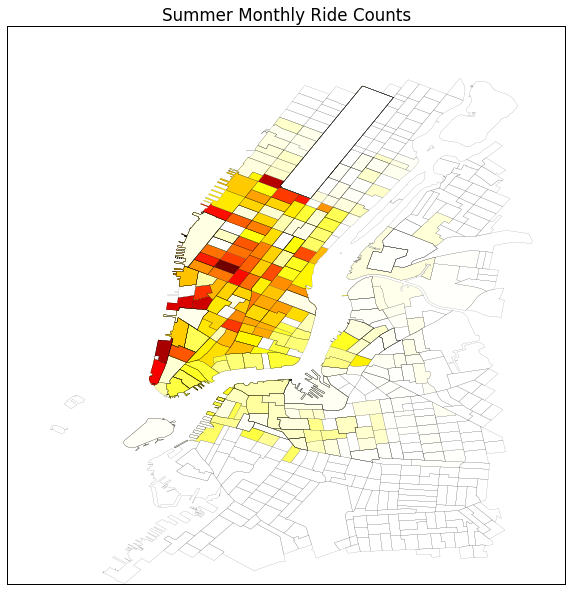

In [29]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve_summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

### Map the monthly rides in Winter

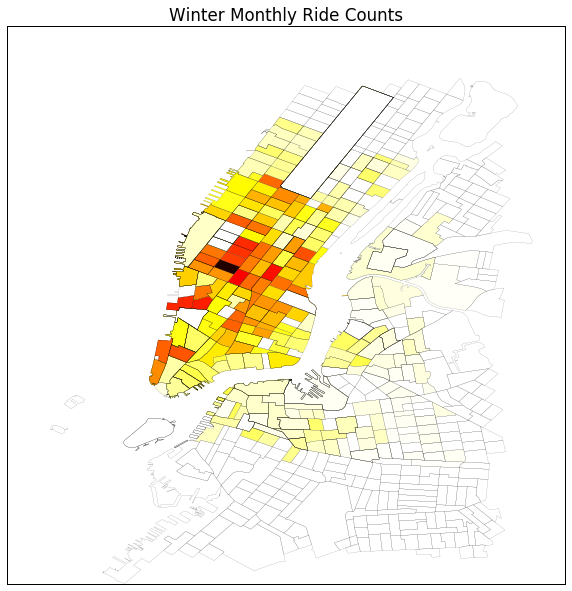

In [30]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve_winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [31]:
path=os.getenv('PUIDATA') + '/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [32]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [33]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [34]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [35]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [36]:
Wmatrix, ids = qW_CT.full()

In [37]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [38]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

#### Summer Observations

In [74]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve_summer
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [75]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    88.000                 2
   88.000 < x[i] <=  1511.625                78
 1511.625 < x[i] <=  3075.000                80
 3075.000 < x[i] <=  7551.400                81
 7551.400 < x[i] <= 11627.857                78
11627.857 < x[i] <= 25693.803                79
25693.803 < x[i] <= 37395.214                80
37395.214 < x[i] <= 43198.655                79
43198.655 < x[i] <= 66036.500                80

#### Map the SUMMER monthly rides lag

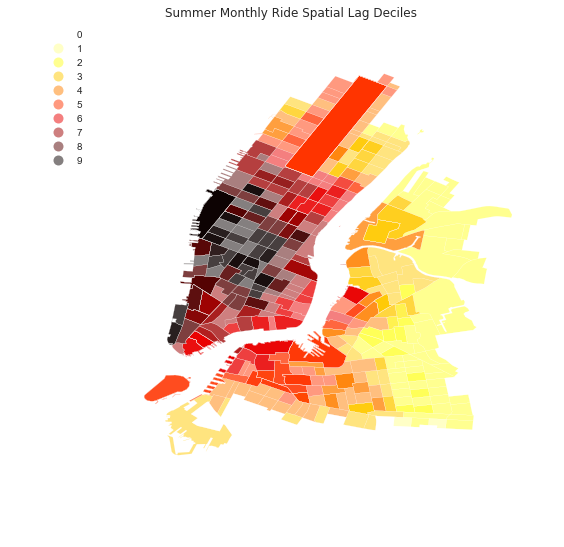

In [76]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles")


## Global  Spatial Autocorrelation - Summer

In [77]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.64389314312589119, 5682.9310787418517)

### Moran Scatterplot - Summer

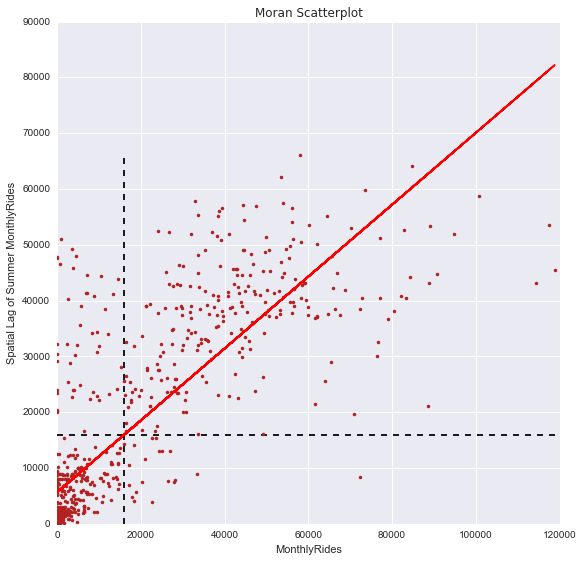

In [78]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I - Summer

In [79]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [80]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.6440694990680973, 0.001)

Thus, the $I$ statistic for summer is $0.644$ for this data, and has a very small $p$ value. 

In [81]:
I_MonthlyRide.sim[0:10]

array([-0.02395207,  0.00305095, -0.00496072, -0.01796084, -0.01877593,
       -0.00881734, -0.00562496, -0.02192411, -0.00436514,  0.02584421])

### KDEplot of all of the simulated points - Summer
the vertical line shows the observed value

In [82]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

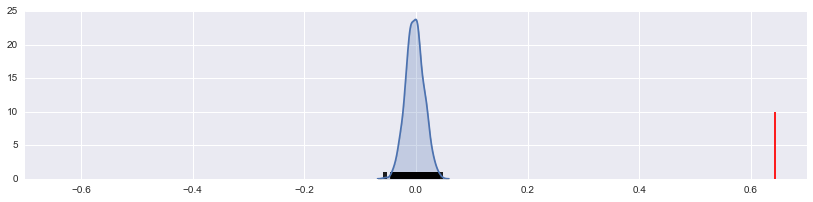

In [83]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

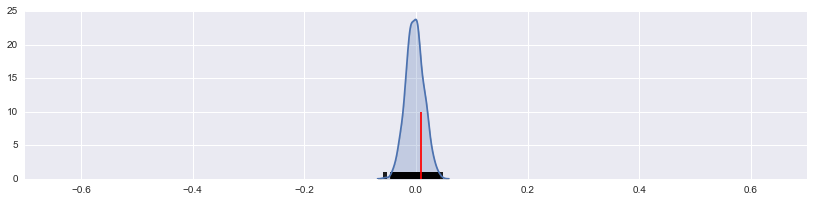

In [84]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation - Summer

In [85]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [86]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.19 ,  0.335,  0.365,  0.37 ]))

### LISA (Local Indicators of Spatial Autocorrelation) - Summer

In [87]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA - Summer

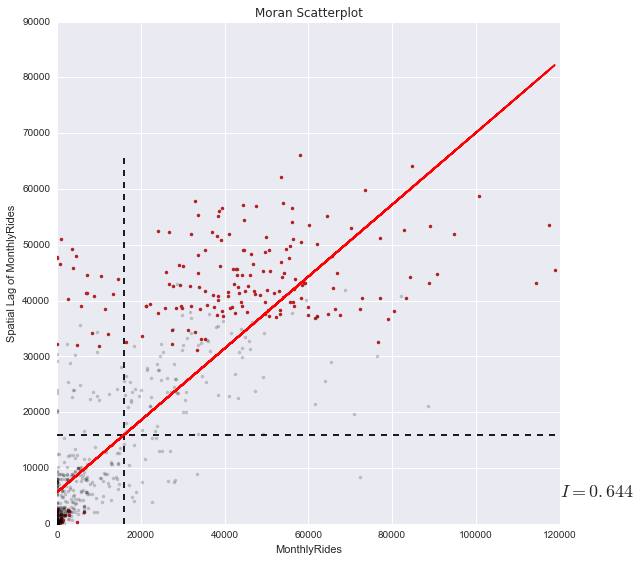

In [88]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


### Hot and Cold spots - Summer

In [91]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Summer Hotspots:", hotspots.sum()
print "Number of Summer Coldspots:", coldspots.sum()

Number of Summer Hotspots: 189
Number of Summer Coldspots: 243


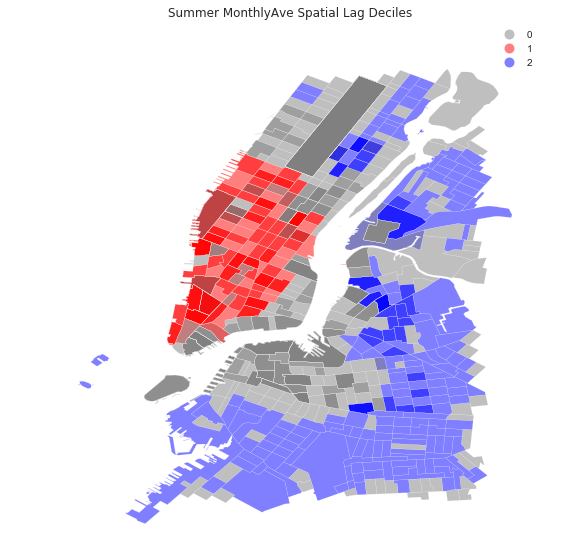

In [92]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer MonthlyAve Spatial Lag Deciles")

#### Winter Observations

In [93]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve_winter
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

In [94]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   902.271                78
  902.271 < x[i] <=  2165.333                80
 2165.333 < x[i] <=  3452.913                79
 3452.913 < x[i] <=  5014.083                80
 5014.083 < x[i] <= 11249.113                79
11249.113 < x[i] <= 15205.882                80
15205.882 < x[i] <= 18477.420                79
18477.420 < x[i] <= 29902.786                80

#### Map the WINTER monthly rides lag

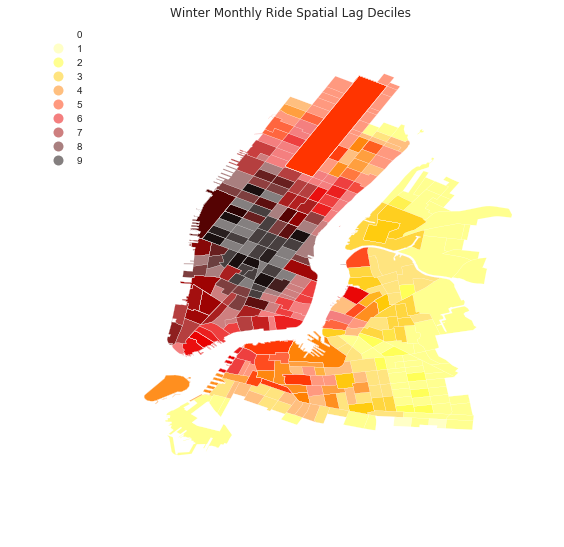

In [95]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation - WINTER

In [96]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.66189462250696818, 2331.8176412763351)

### Moran Scatterplot - Winter

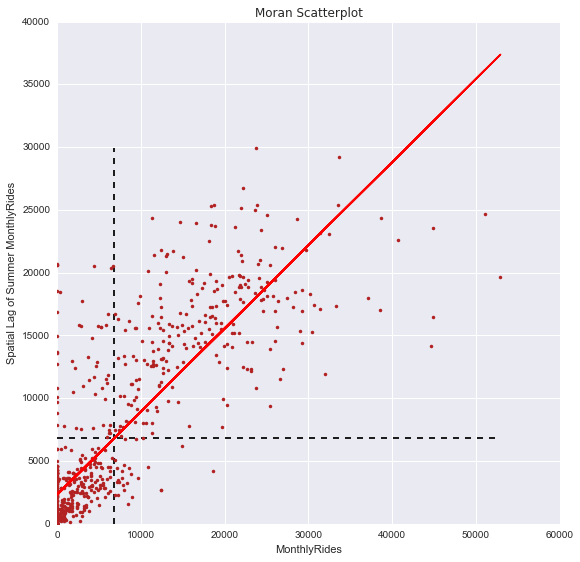

In [97]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I - Winter

In [98]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [99]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.66204419671059411, 0.001)

Thus, the $I$ statistic for winter is $0.662$ for this data, and has a very small $p$ value. 

In [100]:
I_MonthlyRide.sim[0:10]

array([ 0.02367006, -0.00971682, -0.01874453, -0.02977414, -0.0351447 ,
        0.02576734, -0.00216549,  0.01020363,  0.01777997,  0.01038719])

### KDEplot of all of the simulated points - Winter
the vertical line shows the observed value

In [101]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

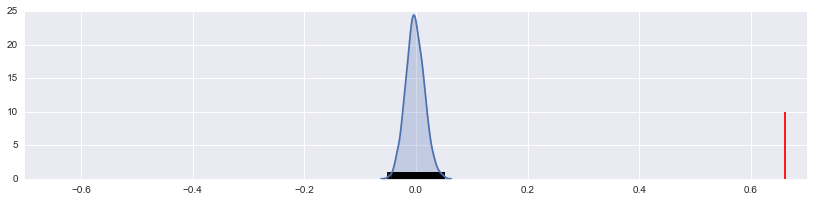

In [102]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

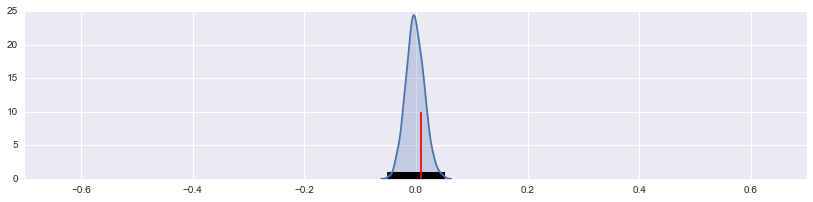

In [103]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation - Winter

In [104]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [105]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.14 ,  0.451,  0.48 ,  0.447]))

### LISA (Local Indicators of Spatial Autocorrelation) - Winter

In [106]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA - Winter

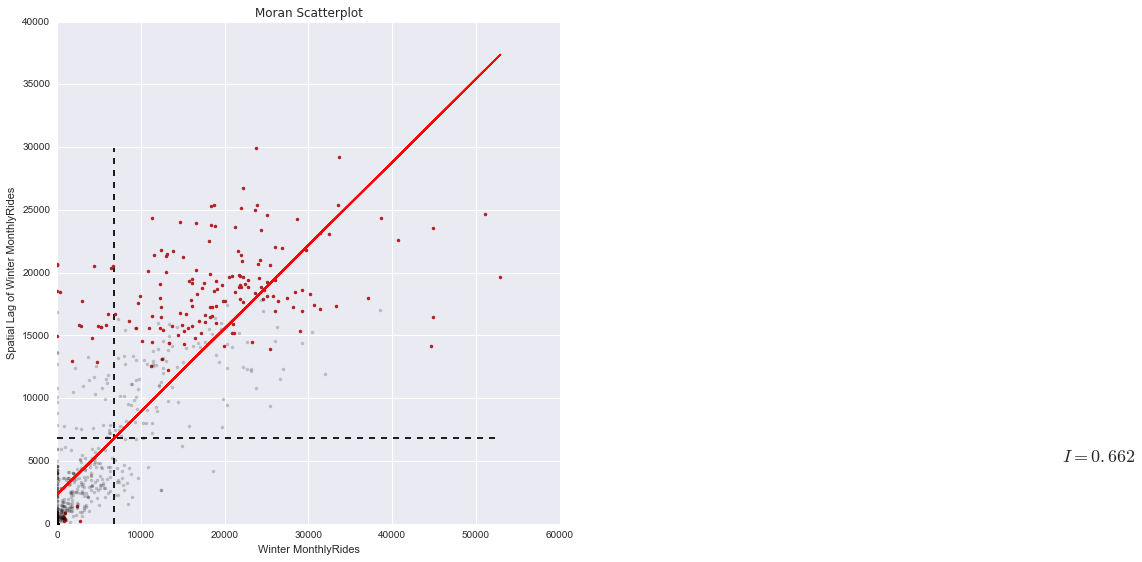

In [107]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter MonthlyRides')
plt.xlabel('Winter MonthlyRides')


### Hot and Cold spots - Winter

In [112]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Winter Hotspots:", hotspots.sum()
print "Number of Winter Coldspots:", coldspots.sum()

Number of Winter Hotspots: 195
Number of Winter Coldspots: 213


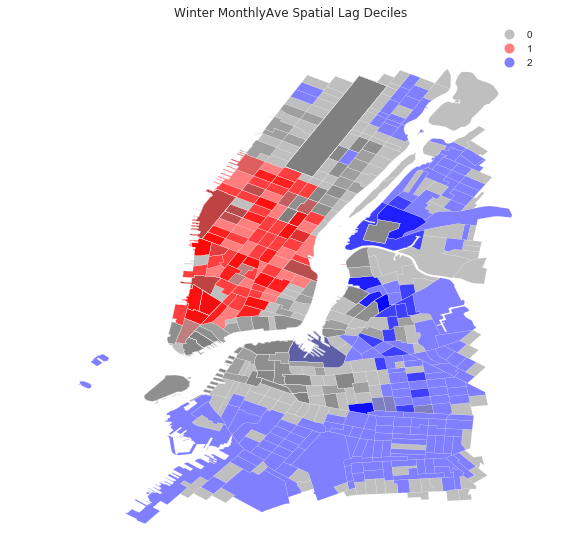

In [113]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter MonthlyAve Spatial Lag Deciles")